# [ATM 623: Climate Modeling](../index.ipynb)
[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany
# Lecture 7: Grey radiation modeling with climlab

## Contents

1. [Introducing `climlab`](#section1)
2. [Using `climlab` to implement the two-layer leaky greenhouse model](#section2)
3. [The observed annual, global mean temperature profile](#section3)
4. [A 30-layer model using the observed temperatures](#section4)
5. [Radiative forcing in the 30-layer model](#section5)
6. [Radiative equilibrium in the 30-layer model](#section6)
7. [Radiative-Convective Equilibrium in the 30-layer model](#section7)
8. [Putting stratospheric ozone in the grey-gas model](#section8)

____________
<a id='section1'></a>

## 1. Introducing `climlab`
____________

``climlab`` is a flexible engine for process-oriented climate modeling.
It is based on a very general concept of a model as a collection of individual, 
interacting processes. ``climlab`` defines a base class called ``Process``, which
can contain an arbitrarily complex tree of sub-processes (each also some 
sub-class of ``Process``). Every climate process (radiative, dynamical, 
physical, turbulent, convective, chemical, etc.) can be simulated as a stand-alone
process model given appropriate input, or as a sub-process of a more complex model. 
New classes of model can easily be defined and run interactively by putting together an
appropriate collection of sub-processes.

``climlab`` is a work-in-progress, and the code base will evolve substantially over the course of this semester.
The latest code can always be found on ``github``:

https://github.com/brian-rose/climlab

You are strongly encouraged to clone the ``climlab`` repository and use ``git`` to keep your local copy up-to-date.

Running this notebook requires that ``climlab`` is already installed on your system.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import climlab

____________
<a id='section2'></a>

## 2. Using `climlab` to implement the two-layer leaky greenhouse model
____________

One of the things that ``climlab`` is set up to do is the grey-radiation modeling we have already been discussing.

Since we already derived a [complete analytical solution to the two-layer leaky greenhouse model](Lecture06 -- Elementary greenhouse models.ipynb), we will use this to validate the `climlab` code.



### Validation

We want to verify that the model reproduces the observed OLR given observed temperatures, and the absorptivity that we tuned in the analytical model. The target numbers are:

\begin{align}
T_s &= 288 \text{ K} \\
T_0 &= 275 \text{ K} \\
T_1 &= 230 \text{ K} \\
\end{align}

$$ \epsilon = 0.58377  $$

$$ OLR = 239 \text{ W m}^{-2} $$


### Initialize a model in `climlab`
The first thing we do is create a new model.

The following example code is sparsely commented but will hopefully orient you on the basics of defining and working with a `climlab Process` object.

In [2]:
#  Test in a 2-layer atmosphere
col = climlab.GreyRadiationModel(num_lev=2)
print col

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (2,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [3]:
col.subprocess

{'LW': <climlab.radiation.radiation.Radiation at 0x1108a0290>,
 'SW': <climlab.radiation.radiation.RadiationSW at 0x103f8d450>,
 'insolation': <climlab.radiation.insolation.FixedInsolation at 0x103f8d310>,
 'surface': <climlab.surface.surface_radiation.SurfaceRadiation at 0x1108a0310>}

In [4]:
col.state

{'Tatm': Field([ 278.,  200.]), 'Ts': Field([ 288.])}

In [5]:
col.Ts

Field([ 288.])

In [6]:
col.Ts[:] = 288.
col.Tatm[:] = np.array([275., 230.])
col.state

{'Tatm': Field([ 275.,  230.]), 'Ts': Field([ 288.])}

In [7]:
LW = col.subprocess['LW']
print LW

climlab Process of type <class 'climlab.radiation.radiation.Radiation'>. 
State variables and domain shapes: 
  Tatm: (2,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.radiation.radiation.Radiation'>



In [8]:
LW.absorptivity

Field([ 0.47737425,  0.47737425])

In [9]:
LW.absorptivity = 0.58377
LW.absorptivity

Field([ 0.58377,  0.58377])

In [10]:
#  This does all the calculations that would be performed at each time step, 
#  but doesn't actually update the temperatures
col.compute_diagnostics()
col.diagnostics

{'ASR': Field([ 239.2513]),
 'LW_absorbed_atm': array([-96.82138041,  20.03935568]),
 'LW_absorbed_sfc': Field([-162.23386935]),
 'LW_down_sfc': array([ 227.87116061]),
 'LW_emission': Field([ 189.31461699,   92.63278385]),
 'LW_up_sfc': Field([ 390.10502995]),
 'OLR': array([ 239.01589408]),
 'SW_absorbed_atm': array([-0., -0.]),
 'SW_absorbed_sfc': Field([ 239.2513]),
 'SW_absorbed_total': 239.25130000000001,
 'SW_down_TOA': Field([ 341.3]),
 'SW_down_sfc': array([ 341.3]),
 'SW_emission': Field([ 0.,  0.]),
 'SW_up_TOA': array([ 102.0487]),
 'SW_up_sfc': Field([ 0.]),
 'insolation': Field([ 341.3]),
 'planetary_albedo': Field([ 0.299])}

In [11]:
#  Check OLR against our analytical solution
col.diagnostics['OLR']

array([ 239.01589408])

In [12]:
col.state

{'Tatm': Field([ 275.,  230.]), 'Ts': Field([ 288.])}

In [13]:
# perform a single time step
col.step_forward()

In [14]:
col.state

{'Tatm': Field([ 273.36692033,  230.33800245]), 'Ts': Field([ 289.59144429])}

In [15]:
# integrate out to radiative equilibrium
col.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 2.00962539378 years.


In [16]:
# Check for equilibrium
col.diagnostics['ASR'] - col.diagnostics['OLR']

Field([ -5.20579960e-07])

In [17]:
#  Compare these temperatures against our analytical solutions for radiative equilibrium
col.state

{'Tatm': Field([ 262.08988341,  233.62925798]), 'Ts': Field([ 296.20384538])}

So it looks like `climlab` agrees with our analytical results. That's good.

____________
<a id='section3'></a>

## 3. The observed annual, global mean temperature profile
____________

We want to model the OLR in a column whose temperatures match observations. As we've done before, we'll calculate the global, annual mean air temperature from the NCEP Reanalysis data.

In [18]:
# This will try to read the data over the internet.
#  If you have a local copy of the data, just use the local path to the .nc file instead of the URL
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = nc.Dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc" )
level = ncep_air.variables['level'][:]
lat = ncep_air.variables['lat'][:]
# A log-pressure height coordinate
zstar = -np.log(level/1000)

In [19]:
Tzon = np.mean(ncep_air.variables['air'][:],axis=(0,3))
Tglobal = np.average( Tzon , weights=np.cos(np.deg2rad(lat)), axis=1) + climlab.constants.tempCtoK
#  Note the useful conversion factor. climlab.constants has lots of commonly used constant pre-defined

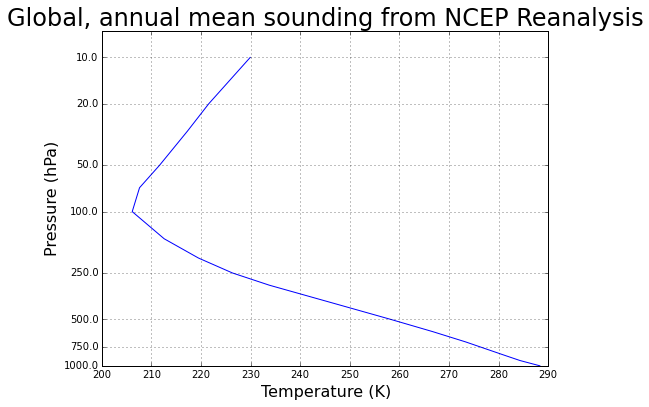

In [20]:
#  Here we are plotting with respect to log(pressure) but labeling the axis in pressure units
fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(111)
ax.plot( Tglobal , zstar )
yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10.])
ax.set_yticks(-np.log(yticks/1000.))
ax.set_yticklabels(yticks)
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('Global, annual mean sounding from NCEP Reanalysis', fontsize = 24)
ax.grid()

____________
<a id='section4'></a>

## 4. A 30-layer model using the observed temperatures
____________



In [21]:
#  initialize a grey radiation model with 30 levels
col = climlab.GreyRadiationModel()
print col

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [22]:
# interpolate to 30 evenly spaced pressure levels
lev = col.lev
Tinterp = np.flipud(np.interp(np.flipud(lev), np.flipud(level), np.flipud(Tglobal)))
Tinterp
#  Need to 'flipud' because the interpolation routine needs the pressure data to be in increasing order

array([ 287.4463874 ,  285.6810201 ,  283.98269653,  282.48550415,
        280.98831177,  279.29533895,  277.60236613,  275.90939331,
        274.21642049,  272.25855509,  270.03579712,  267.81303914,
        265.29490662,  262.48139954,  259.66789246,  256.48087056,
        252.92033386,  249.35979716,  245.279658  ,  240.67991638,
        236.08017476,  231.30422974,  226.3520813 ,  221.78252157,
        217.19397481,  212.58644104,  208.29142761,  206.96233453,
        211.66334534,  224.34736633])

In [23]:
# Initialize model with observed temperatures
col.Ts[:] = Tglobal[0]
col.Tatm[:] = Tinterp

In [24]:
#  A handy re-usable routine for making a plot of the temperature profiles
#  We will plot temperatures with respect to log(pressure) to get a height-like coordinate
def plot_sounding(collist):
    color_cycle=['r', 'g', 'b', 'y']
    # col is either a column model object or a list of column model objects
    if isinstance(collist, climlab.Process):
        # make a list with a single item
        collist = [collist]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i, col in enumerate(collist):
        zstar = -np.log(col.lev/climlab.constants.ps)
        ax.plot(col.Tatm, zstar, color=color_cycle[i])
        ax.plot(col.Ts, 0, 'o', markersize=12, color=color_cycle[i])
    #ax.invert_yaxis()
    yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10.])
    ax.set_yticks(-np.log(yticks/1000.))
    ax.set_yticklabels(yticks)
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Pressure (hPa)')
    ax.grid()
    return ax

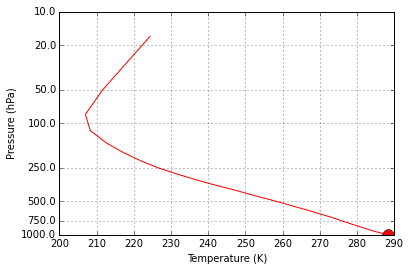

In [25]:
# This should look just like the observations
plot_sounding(col)

### Tune absorptivity to get observed OLR

In [26]:
col.compute_diagnostics()
col.diagnostics['OLR']

array([ 263.15000167])

In [27]:
# Need to tune absorptivity to get OLR = 239
epsarray = np.linspace(0.01, 0.1, 100)
OLRarray = np.zeros_like(epsarray)

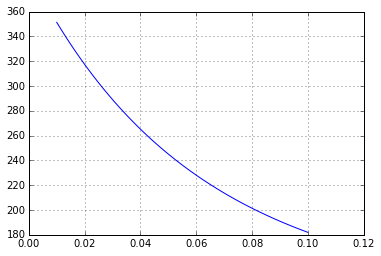

In [28]:
for i in range(epsarray.size):
    col.subprocess['LW'].absorptivity = epsarray[i]
    col.compute_diagnostics()
    OLRarray[i] = col.diagnostics['OLR']

plt.plot(epsarray, OLRarray)
plt.grid()

The necessary value seems to lie near 0.055 or so.

We can be more precise with a numerical root-finder.

In [29]:
def OLRanom(eps):
    col.subprocess['LW'].absorptivity = eps
    col.compute_diagnostics()
    return col.diagnostics['OLR'] - 239.

In [30]:
# Use numerical root-finding to get the equilibria
from scipy.optimize import brentq
# brentq is a root-finding function
#  Need to give it a function and two end-points
#  It will look for a zero of the function between those end-points
eps = brentq(OLRanom, 0.01, 0.1)
print eps

0.0534031813092


In [31]:
col.subprocess['LW'].absorptivity = eps
col.subprocess['LW'].absorptivity

Field([ 0.05340318,  0.05340318,  0.05340318,  0.05340318,  0.05340318,
        0.05340318,  0.05340318,  0.05340318,  0.05340318,  0.05340318,
        0.05340318,  0.05340318,  0.05340318,  0.05340318,  0.05340318,
        0.05340318,  0.05340318,  0.05340318,  0.05340318,  0.05340318,
        0.05340318,  0.05340318,  0.05340318,  0.05340318,  0.05340318,
        0.05340318,  0.05340318,  0.05340318,  0.05340318,  0.05340318])

In [32]:
col.compute_diagnostics()
col.diagnostics['OLR']

array([ 239.])

____________
<a id='section5'></a>

## 5. Radiative forcing in the 30-layer model
____________

Let's compute radiative forcing for a **2% increase in absorptivity**.

In [33]:
#  clone our model using a built-in climlab function
col2 = climlab.process_like(col)
print col2

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



In [34]:
col2.subprocess['LW'].absorptivity *= 1.02
col2.subprocess['LW'].absorptivity

Field([ 0.05447124,  0.05447124,  0.05447124,  0.05447124,  0.05447124,
        0.05447124,  0.05447124,  0.05447124,  0.05447124,  0.05447124,
        0.05447124,  0.05447124,  0.05447124,  0.05447124,  0.05447124,
        0.05447124,  0.05447124,  0.05447124,  0.05447124,  0.05447124,
        0.05447124,  0.05447124,  0.05447124,  0.05447124,  0.05447124,
        0.05447124,  0.05447124,  0.05447124,  0.05447124,  0.05447124])

In [35]:
#  Radiative forcing by definition is the change in TOA radiative flux, HOLDING THE TEMPERATURES FIXED.
col2.Ts - col.Ts

Field([ 0.])

In [36]:
col2.Tatm - col.Tatm

Field([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [37]:
col2.compute_diagnostics()
col2.diagnostics['OLR']

array([ 237.15483194])

The OLR decreased after we added the extra absorbers, as we expect. Now we can calculate the Radiative Forcing:

In [38]:
RF = -(col2.diagnostics['OLR'] - col.diagnostics['OLR'])
print 'The radiative forcing is %f W/m2.' %RF

The radiative forcing is 1.845168 W/m2.


____________
<a id='section6'></a>

## 6. Radiative equilibrium in the 30-layer model
____________


In [39]:
re = climlab.process_like(col)

In [40]:
#  To get to equilibrium, we just time-step the model forward long enough
re.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 2.91039753895 years.


In [41]:
#  Check for energy balance
re.diagnostics['ASR'] - re.diagnostics['OLR']

Field([ -8.67412012e-07])

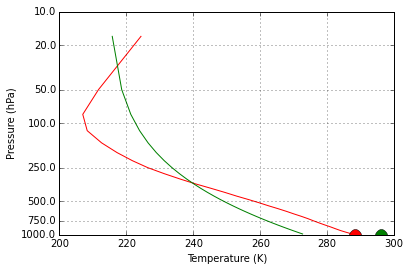

In [42]:
plot_sounding([col, re])

Some properties of the **radiative equilibrium** temperature profile:

- The surface is warmer than observed.
- The lower troposphere is colder than observed.
- Very cold air is sitting immediately above the warm surface.
- There is no tropopause, no stratosphere.

____________
<a id='section7'></a>

## 7. Radiative-Convective Equilibrium in the 30-layer model
____________

We recognize that the large drop in temperature just above the surface is unphysical. Parcels of air in direct contact with the ground will be warmed by mechansisms other than radiative transfer.

These warm air parcels will then become buoyant, and will convect upward, mixing their heat content with the environment.

We **parameterize** the statistical effects of this mixing through a **convective adjustment**. 

At each timestep, our model checks for any locations at which the **lapse rate** exceeds some threshold. Unstable layers are removed through an energy-conserving mixing formula.

This process is assumed to be fast relative to radiative heating. In the model, it is instantaneous.

In [43]:
rce = climlab.RadiativeConvectiveModel(adj_lapse_rate=6.)
print rce

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.RadiativeConvectiveModel'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



This model is exactly like our previous models, except for one additional subprocess called ``convective adjustment``. 

We passed a parameter ``adj_lapse_rate`` (in K / km) that sets the neutrally stable lapse rate -- in this case, 6 K / km.

This number is chosed to very loosely represent the net effect of **moist convection**. We'll look at this in more detail later.

In [44]:
# Set our tuned absorptivity value
rce.subprocess['LW'].absorptivity = eps

In [45]:
#  Run out to equilibrium
rce.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.


In [46]:
#  Check for energy balance
rce.diagnostics['ASR'] - rce.diagnostics['OLR']

Field([  6.23502038e-06])

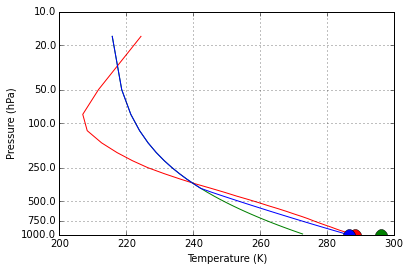

In [47]:
#  Make a plot to compare observations, Radiative Equilibrium, and Radiative-Convective Equilibrium
plot_sounding([col, re, rce])

Introducing convective adjustment into the model cools the surface quite a bit (compared to Radiative Equilibrium, in green here) -- and warms the lower troposphere. It gives us a MUCH better fit to observations.

But of course we still have no stratosphere.

____________
<a id='section8'></a>

## 8. Putting stratospheric ozone in the grey-gas model
____________

Our model has no equivalent of the stratosphere, where temperature increases with height. That's because our model has been completely transparent to shortwave radiation up until now.

We can load the observed ozone climatology from the input files for the CESM model:

In [48]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"

ozone = nc.Dataset( datapath + 'som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc' + endstr )

In [49]:
print ozone.variables['O3']

<type 'netCDF4.Variable'>
float32 O3(time, lev, lat, lon)
    units: mol/mol
    long_name: O3 concentration
    cell_method: time: mean
unlimited dimensions: time
current shape = (12, 26, 96, 144)
filling off



In [50]:
lat_O3 = ozone.variables['lat'][:]
lon_O3 = ozone.variables['lon'][:]
lev_O3 = ozone.variables['lev'][:]

The pressure levels in this dataset are:

In [51]:
print lev_O3

[   3.544638     7.3888135   13.967214    23.944625    37.23029     53.114605
   70.05915     85.439115   100.514695   118.250335   139.115395   163.66207
  192.539935   226.513265   266.481155   313.501265   368.81798    433.895225
  510.455255   600.5242     696.79629    787.70206    867.16076    929.648875
  970.55483    992.5561   ]


### Take the global average of the ozone climatology, and plot it as a function of pressure (or height)

In [52]:
O3_zon = np.mean( ozone.variables['O3'][:],axis=(0,3) )
print O3_zon.shape

(26, 96)


In [53]:
O3_global = np.average( O3_zon, axis=1, weights=np.cos(np.deg2rad(lat_O3)))
print O3_global

[  7.82792904e-06   8.64150570e-06   7.58940041e-06   5.24567122e-06
   3.17761578e-06   1.82320025e-06   9.80756909e-07   6.22870516e-07
   4.47620522e-07   3.34481172e-07   2.62570325e-07   2.07898125e-07
   1.57074552e-07   1.12425546e-07   8.06005076e-08   6.27826466e-08
   5.42990612e-08   4.99506108e-08   4.60075675e-08   4.22977777e-08
   3.80559086e-08   3.38768551e-08   3.12171622e-08   2.97807148e-08
   2.87980981e-08   2.75429919e-08]


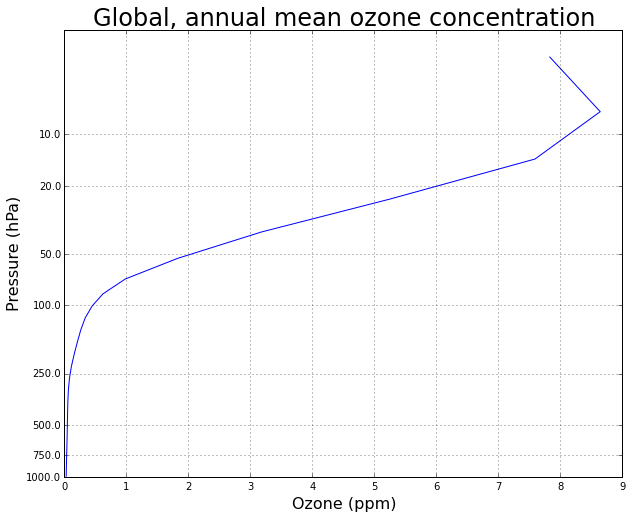

In [54]:
ax = plt.figure(figsize=(10,8)).add_subplot(111)
ax.plot( O3_global * 1.E6, -np.log(lev_O3/climlab.constants.ps) )
ax.set_xlabel('Ozone (ppm)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( -np.log(yticks/1000.) )
ax.set_yticklabels( yticks )
ax.grid()
ax.set_title('Global, annual mean ozone concentration', fontsize = 24);

This shows that most of the ozone is indeed in the stratosphere, and peaks near the top of the stratosphere.

Now create a new column model object **on the same pressure levels as the ozone data**.  We are also going set an adjusted lapse rate of 6 K / km.

In [55]:
oz_col = climlab.RadiativeConvectiveModel(lev = lev_O3, adj_lapse_rate=6)
print oz_col

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Tatm: (26,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.RadiativeConvectiveModel'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



Now we will do something new: let the column absorb some shortwave radiation. We will assume that the shortwave absorptivity is proportional to the ozone concentration we plotted above. 

First we have to deal with a little inconsistency:

In [56]:
print lev_O3
print oz_col.lev

[   3.544638     7.3888135   13.967214    23.944625    37.23029     53.114605
   70.05915     85.439115   100.514695   118.250335   139.115395   163.66207
  192.539935   226.513265   266.481155   313.501265   368.81798    433.895225
  510.455255   600.5242     696.79629    787.70206    867.16076    929.648875
  970.55483    992.5561   ]
[ 992.5561     970.55483    929.648875   867.16076    787.70206    696.79629
  600.5242     510.455255   433.895225   368.81798    313.501265
  266.481155   226.513265   192.539935   163.66207    139.115395
  118.250335   100.514695    85.439115    70.05915     53.114605    37.23029
   23.944625    13.967214     7.3888135    3.544638 ]


The two arrays are in reverse order!

So we need to flip the ozone data before using it:

In [57]:
O3_flipped = np.flipud(O3_global)

Now we need to weight the absorptivity by the pressure (mass) of each layer.

In [58]:
# This number is an arbitrary parameter that scales how absorptive we are making the ozone
# in our grey gas model
ozonefactor = 75
dp = oz_col.Tatm.domain.lev.delta
epsSW = np.flipud(O3_global) * dp * ozonefactor

We want to use the field `epsSW` as the absorptivity for our SW radiation model.

Let's see what the absorptivity is current set to:

In [59]:
print oz_col.subprocess['SW'].absorptivity

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


It defaults to zero.

Before changing this (putting in the ozone), let's take a look at the shortwave absorption in the column:

In [60]:
oz_col.compute_diagnostics()

In [61]:
oz_col.diagnostics['SW_absorbed_atm']

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])

Let's now put in the ozone:

In [62]:
oz_col.subprocess['SW'].absorptivity = epsSW
print oz_col.subprocess['SW'].absorptivity

[  3.81013258e-05   6.79353164e-05   1.15468099e-04   1.66169128e-04
   2.16427967e-04   2.67120883e-04   2.95567938e-04   2.87482268e-04
   2.65307565e-04   2.45147963e-04   2.40936627e-04   2.62922886e-04
   3.11733077e-04   3.70212125e-04   4.16507314e-04   4.47141525e-04
   4.84170276e-04   5.50761578e-04   7.11369789e-04   1.18884324e-03
   2.24450947e-03   3.47591208e-03   4.57614181e-03   4.71182560e-03
   3.37750312e-03   3.20948559e-03]


Let's check how this changes the SW absorption:

In [63]:
oz_col.compute_diagnostics()
oz_col.diagnostics['SW_absorbed_atm']

array([ 0.01641658,  0.02927233,  0.04975715,  0.07161233,  0.09328389,
        0.11515129,  0.12743552,  0.12396838,  0.11442202,  0.1057411 ,
        0.10393805,  0.11343945,  0.13452308,  0.1597929 ,  0.17981756,
        0.19309136,  0.20913838,  0.23797741,  0.30750441,  0.51429087,
        0.97239294,  1.50916588,  1.99236556,  2.05685577,  1.47671292,
        1.40571625])

It is now non-zero, and largest near the top of the column (bottom of array) where the ozone concentration is highest.

Now it's time to run the model out to radiative-convective equilibrium

In [64]:
oz_col.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 1.01576433391 years.


In [65]:
print oz_col.diagnostics['ASR'] - oz_col.diagnostics['OLR']

[-0.00553705]


And let's now see what we got!

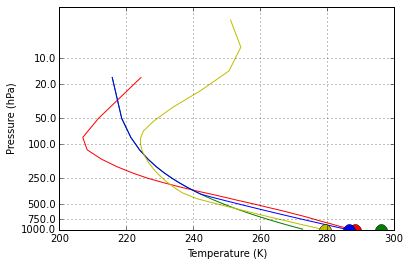

In [66]:
#  Make a plot to compare observations, Radiative Equilibrium, Radiative-Convective Equilibrium, and RCE with ozone!
plot_sounding([col, re, rce, oz_col])

And we finally have something that looks looks like the tropopause, with temperature increasing above at approximately the correct rate. 

There are still plenty of discrepancies between this model solution and the observations, including:

- Tropopause temperature is too warm, by about 15 degrees.
- Surface temperature is too cold

There are a number of parameters we might adjust if we wanted to improve the fit, including:

- Longwave absorptivity
- Surface albedo

Feel free to experiment! (That's what models are for, after all).

### The take home message

The dominant effect of stratospheric ozone is to vastly increase the radiative equilibrium temperature in the ozone layer. The temperature needs to be higher so that the longwave emission can balance the shortwave absorption.

Without ozone to absorb incoming solar radiation, the **temperature does not increase with height**.

This simple grey-gas model illustrates this principle very clearly.

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php), offered in Spring 2015.
____________

____________
## Version information
____________



In [67]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, climlab

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 2.7.9 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 3.1.0
OS Darwin 13.4.0 x86_64 i386 64bit
numpy 1.9.2
climlab 0.2.9
Wed Apr 22 10:27:26 2015 EDT